In [99]:
import numpy as np
import os
import tempfile
from pdf2image import convert_from_path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import pandas as pd
import tqdm
import pytesseract

In [2]:
dpi = 400
dpi_scale = int(dpi / 200)

In [32]:
# list_of_main_folders = glob('../Desktop/task3/6*/')
# list_of_main_folders

In [124]:
dpi_scale

2

In [80]:
pathes_to_pdfs = []
for folder in glob('../Desktop/task3/6*/'):
    path = os.path.join(folder, 'Well_logs/')
    pathes_to_pdfs.append(path)
# well_x_path = glob('../Desktop/task3/W*/W*/') # for Well X
# pathes_to_pdfs.append(well_x_path[0])
pathes_to_pdfs.remove('../Desktop/task3/6507 7-4/Well_logs/')
pathes_to_pdfs

['../Desktop/task3/6201 11-2/Well_logs/',
 '../Desktop/task3/6406 3-2/Well_logs/',
 '../Desktop/task3/6204 11-1/Well_logs/',
 '../Desktop/task3/6201 11-1/Well_logs/',
 '../Desktop/task3/6204 10-2 R/Well_logs/',
 '../Desktop/task3/6204 10-2 A/Well_logs/',
 '../Desktop/task3/6506 12-5/Well_logs/']

In [225]:
def get_log(thresh, dist):
    
    masks = dist < thresh
    raw = np.arange(masks.shape[1])[:, None]
    map_ = np.tile(raw, [len(masks), 1, 1])
    raw_mask = (map_ * masks)
    logs = []
    for i in raw_mask:
        logs.append(i[i != 0].mean())
        
    return logs


def crop_gr_head(img, scale):
    return img[361*scale:760*scale, 339*scale:736*scale]


def crop_gr_graph(img, scale):
    return img[765*scale:-5, 342*scale:736*scale]


def crop_co_head(img, scale):
    return img[250*scale:760*scale, 980*scale:1380*scale]


def crop_co_graph(img, scale): # 80%
    return img[765*scale:-5,980*scale:int(1380*scale - 400*scale*0.2)]


def crop_sonic_head(img, scale):
    return img[650*scale:760*scale, 1380*scale:1780*scale]


def crop_sonic_graph(img, scale):
    return img[765*scale:-5,1380*scale:1780*scale]


def crop_resist_head(img, scale):
    return img[450*scale:760*scale,1780*scale:2180*scale]


def crop_resist_graph(img, scale):
    return img[765*scale:-5,1780*scale:2180*scale]

In [705]:
def make_dataset(path_to_pdf, dpi_scale):
    
    filename = glob(os.path.join(path_to_pdf, '*.pdf'))[0]

    with tempfile.TemporaryDirectory() as path:
        images_from_path = convert_from_path(filename, output_folder=path, last_page=0, first_page=0, dpi=400)

    base_filename = os.path.splitext(os.path.basename(filename))[0] + '.jpg'     

    save_dir = path_to_pdf

    for page in images_from_path:
        pic_path = os.path.join(save_dir, base_filename)
        page.save(pic_path, 'JPEG')
    
    img = cv2.imread(pic_path,1)
    img1 = imutils.resize(img)
    
    # Gamma ray
    GR_header = crop_gr_head(img1, dpi_scale).astype('int64')
    GR_graph = crop_gr_graph(img1, dpi_scale).astype('int64')
    
    ## Gamma ray log
    gr_line = np.array([0, 0, 0])
    gr_dist = np.sqrt(((GR_graph[..., None, :] - gr_line[None]) ** 2).sum(-1))
    gr_logs = get_log(30, gr_dist)[::-1]
    
    ## Caliper log
    cal_line = np.array([0, 148, 0])
    cal_dist = np.sqrt(((GR_graph[..., None, :] - cal_line[None]) ** 2).sum(-1))
    cal_logs = get_log(100, cal_dist)[::-1]
    
    # CO log
    co_header = crop_co_head(img1, dpi_scale).astype('int64')
    co_graph = crop_co_graph(img1, dpi_scale).astype('int64')
    
    ## Bulk density log
    bulk_line = np.array([0, 0, 211])
    bulk_dist = np.sqrt(((co_graph[..., None, :] - bulk_line[None]) ** 2).sum(-1))
    bulk_logs = get_log(100, bulk_dist)[::-1]
    
    ## Neutron potosity log
    neutron_line = np.array([145, 0,  6])
    neutron_dist = np.sqrt(((co_graph[..., None, :] - neutron_line[None]) ** 2).sum(-1))
    neutron_logs = get_log(100, neutron_dist)[::-1]
    

    # Sonic
    sonic_header = crop_sonic_head(img1, dpi_scale).astype('int64')
    sonic_graph = crop_sonic_graph(img1, dpi_scale).astype('int64')
    
    ## Sonic log
    sonic_line = np.array([243, 107, 71])
    sonic_dist = np.sqrt(((sonic_graph[..., None, :] - sonic_line[None]) ** 2).sum(-1))
    sonic_logs = get_log(100, sonic_dist)[::-1]

    # Resistivity
    resist_header = crop_resist_head(img1, dpi_scale).astype('int64')
    resist_graph = crop_resist_graph(img1, dpi_scale).astype('int64')
    
    # Medium log
    medium_line = np.array([0, 0, 211])
    medium_dist = np.sqrt(((resist_graph[..., None, :] - medium_line[None]) ** 2).sum(-1))
    medium_logs = get_log(100, medium_dist)[::-1]
    
    # DataFrame with logs
    df = pd.DataFrame(data=gr_logs,
                      columns=['gamma_ray_log'])
    df['caliper_log'] = cal_logs
    df['bulk_log'] = bulk_logs
    df['neutron_log'] = neutron_logs
    df['sonic_log'] = sonic_logs
    df['medium_log'] = medium_logs
    
    return df

In [706]:
pathes_to_pdfs

['../Desktop/task3/6201 11-2/Well_logs/',
 '../Desktop/task3/6406 3-2/Well_logs/',
 '../Desktop/task3/6204 11-1/Well_logs/',
 '../Desktop/task3/6201 11-1/Well_logs/',
 '../Desktop/task3/6204 10-2 R/Well_logs/',
 '../Desktop/task3/6204 10-2 A/Well_logs/',
 '../Desktop/task3/6506 12-5/Well_logs/']

In [707]:
%%time

database = dict()
well_names = ['well_' + str(num) for num in range(len(pathes_to_pdfs))]

for i in tqdm.tqdm(range(len(pathes_to_pdfs))):
    database[well_names[i]] = make_dataset(pathes_to_pdfs[i], dpi_scale)



  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:20<02:02, 20.45s/it]

 29%|██▊       | 2/7 [00:44<01:46, 21.38s/it]

 43%|████▎     | 3/7 [00:58<01:17, 19.32s/it]

 57%|█████▋    | 4/7 [01:17<00:57, 19.28s/it]

 71%|███████▏  | 5/7 [01:27<00:33, 16.55s/it]

 86%|████████▌ | 6/7 [01:39<00:14, 14.94s/it]

100%|██████████| 7/7 [02:04<00:00, 17.72s/it]

CPU times: user 1min 3s, sys: 24 s, total: 1min 27s
Wall time: 2min 4s


In [708]:
database['well_0'].describe()

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log
count,26153.000000,23579.000000,20182.000000,3346.000000,23910.000000,17544.000000
mean,255.778463,448.506902,317.677127,153.417239,476.957988,235.949140
std,135.372151,112.040911,144.654395,112.353561,111.899721,65.965618
min,1.500000,98.000000,1.000000,1.000000,246.000000,87.500000
25%,169.500000,398.000000,189.000000,71.500000,384.000000,202.500000
50%,253.500000,413.500000,358.500000,123.500000,490.000000,231.500000
75%,288.000000,578.000000,435.500000,191.000000,565.000000,253.000000
max,787.000000,770.500000,639.000000,619.500000,727.500000,506.000000


In [709]:
database.keys()

dict_keys(['well_0', 'well_1', 'well_2', 'well_3', 'well_4', 'well_5', 'well_6'])

### Rescale to physical

In [718]:
# scales = [0.38, 0.06, 0.5, 0.5]
scales_max = [0.19, 0.03, 0.00125, 0.0009375, 0.25, 0.25]
for i in database.keys():
    for j,s in zip(database[i], scales_max):
        database[i][j] = database[i][j].apply(lambda x: x*s)

In [719]:
for i in database.keys():
    
    database[i]['bulk_log'] = database[i]['bulk_log'] + 1.95
    database[i]['neutron_log'] = 0.45 - database[i]['neutron_log']

In [720]:
database['well_0']

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log,Depth
0,NaN,NaN,NaN,NaN,NaN,NaN,380.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,380.126991
2,NaN,NaN,NaN,NaN,NaN,NaN,380.253982
3,NaN,NaN,NaN,NaN,NaN,NaN,380.380974
4,NaN,NaN,NaN,NaN,NaN,NaN,380.507965
...,...,...,...,...,...,...,...
26927,2.490900,NaN,NaN,NaN,NaN,NaN,3799.492035
26928,2.472850,NaN,NaN,NaN,NaN,NaN,3799.619026
26929,2.525663,NaN,NaN,NaN,NaN,NaN,3799.746018
26930,2.508950,NaN,NaN,NaN,NaN,NaN,3799.873009


### Depth Creation

In [716]:
low_depth = [380, 300, 200, 380, 200, 200, 270]  # tesseract
high_depth = [3800, 4420, 2980, 3860, 2190, 2290, 4940]

for l,h,i in zip(low_depth, high_depth, database.keys()):
    database[i]['Depth']  = np.linspace(l, h, database[i].shape[0])

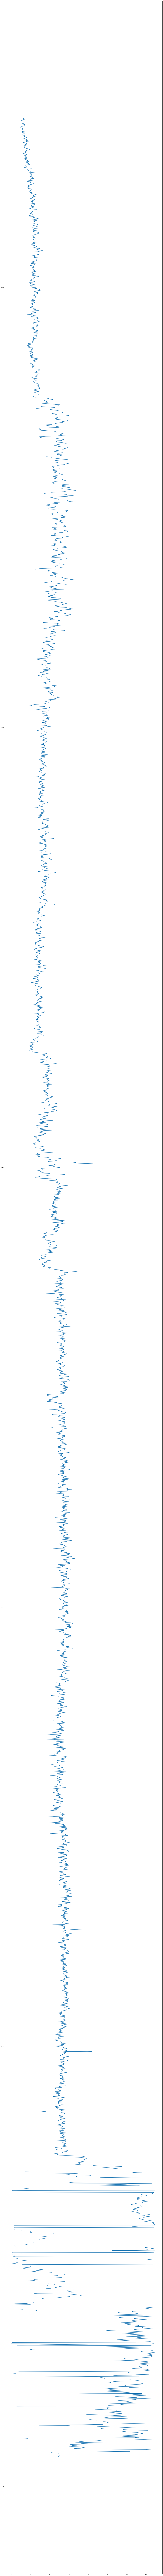

In [320]:
plt.figure(figsize = (30, 500))
plt.plot(database['well_0']['gamma_ray_log'], range(database['well_0'].shape[0]));

In [321]:
# database_no_depth = database['well_0'].drop('Depth', axis = 1)

In [717]:
database['well_0']

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log,Depth
0,NaN,NaN,NaN,NaN,NaN,NaN,380.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,380.126991
2,NaN,NaN,NaN,NaN,NaN,NaN,380.253982
3,NaN,NaN,NaN,NaN,NaN,NaN,380.380974
4,NaN,NaN,NaN,NaN,NaN,NaN,380.507965
...,...,...,...,...,...,...,...
26927,13.110000,NaN,NaN,NaN,NaN,NaN,3799.492035
26928,13.015000,NaN,NaN,NaN,NaN,NaN,3799.619026
26929,13.292963,NaN,NaN,NaN,NaN,NaN,3799.746018
26930,13.205000,NaN,NaN,NaN,NaN,NaN,3799.873009


### Clustering

In [520]:
# %% time

scaled = {}
for i in tqdm.tqdm(database.keys()):
    database[i] = database[i].iloc[::8,:]
    
    
    database[i]['gamma_ray_log'].fillna(method ='ffill', inplace=True)
    database[i]['caliper_log'].fillna(method='ffill', inplace = True)
    database[i]['bulk_log'].fillna(method='ffill', inplace = True)
    database[i]['neutron_log'].fillna(method='ffill', inplace = True)
    database[i]['sonic_log'].fillna(database[i].describe().ix[1,'sonic_log'], inplace = True)
    database[i]['medium_log'].fillna(method = 'ffill', inplace = True)
    
   
    database[i]['gamma_ray_log'].fillna(database[i].describe().ix[3,'gamma_ray_log'], inplace=True)
    database[i]['caliper_log'].fillna(database[i].describe().ix[1,'caliper_log'], inplace = True)
    database[i]['bulk_log'].fillna(database[i].describe().ix[3,'bulk_log'], inplace = True)
    database[i]['neutron_log'].fillna(database[i].describe().ix[3,'neutron_log'], inplace = True)
    database[i]['sonic_log'].fillna(method='bfill', inplace = True)
    database[i]['medium_log'].fillna(method='bfill', inplace = True) 

    print(database[i].isnull().sum())
    database[i] = database[i].drop('Depth', axis=1)

#     test_frame['tsne1'] = tsne_repr_2d[:, 0]
#     test_frame['tsne2'] = tsne_repr_2d[:, 1]



  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.81it/s]

gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64
gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64
gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64




 57%|█████▋    | 4/7 [00:00<00:00, 12.25it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.46it/s]



gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64
gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64
gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64


100%|██████████| 7/7 [00:00<00:00, 11.46it/s]

gamma_ray_log    0
caliper_log      0
bulk_log         0
neutron_log      0
sonic_log        0
medium_log       0
Depth            0
dtype: int64


In [521]:
list_tables =  [database['well_0'],database['well_1'] ,database['well_2'] ,database['well_3'] ,database['well_4'] ,database['well_5'] ,database['well_6']]
result = pd.concat(list_tables)
result

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log
0,0.285,13.518914,1.95125,0.01875,119.285295,95.875
8,0.285,13.518914,1.95125,0.01875,119.285295,95.875
16,0.285,13.518914,1.95125,0.01875,119.285295,95.875
24,0.285,13.518914,1.95125,0.01875,119.285295,95.875
32,0.285,13.518914,1.95125,0.01875,119.285295,95.875
...,...,...,...,...,...,...
36856,10.450,22.215000,2.67625,-0.07916,127.321438,62.500
36864,10.450,22.215000,2.67625,-0.07916,127.321438,62.500
36872,10.450,22.215000,2.67625,-0.07916,127.321438,62.500
36880,10.450,22.215000,2.67625,-0.07916,127.321438,62.500


In [523]:
scaler = RobustScaler()
result_scaled = scaler.fit_transform(result)

# labels_dbs = DBSCAN(eps = 2.7, min_samples=10).fit_predict(result_scaled)
# result['Clusters'] = labels_dbs

In [524]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components = 2, random_state = 60, perplexity = 100)
tsne_repr_2d = tsne_2d.fit_transform(result_scaled)

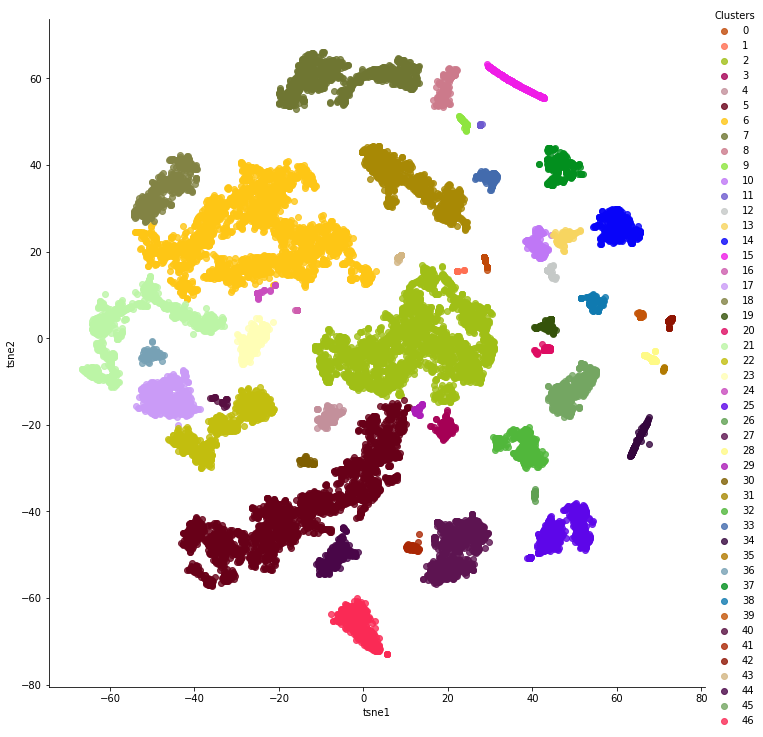

<Figure size 432x288 with 0 Axes>

In [567]:
import seaborn as sns
import random
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

colors = pd.read_excel('../Desktop/Dataframes/Others/colors.xlsx')  #  библиотека красивых цветов
list(colors.iloc[:,0])
colors  = colors.iloc[:,0].str.strip()

random.shuffle(colors)

labels_dbs = DBSCAN(eps = 2.0, min_samples=19).fit_predict(tsne_repr_2d)
result['Clusters'] = labels_dbs


result['tsne1'] = tsne_repr_2d[:, 0]
result['tsne2'] = tsne_repr_2d[:, 1]
final_result = result[result['Clusters'] != -1]


sns.lmplot('tsne1', 'tsne2', data=final_result, hue = 'Clusters', palette=sns.xkcd_palette(colors), fit_reg=False, height=10)
plt.show()
plt.savefig('tnse_whole_database.png', dpi = 250)

In [461]:
low_depth = [380, 300, 200, 380, 200, 200, 270]  # tesseract
high_depth = [3800, 4420, 2980, 3860, 2190, 2290, 4940]

for l,h,i in zip(low_depth, high_depth, database.keys()):
    database[i]['Depth']  = np.linspace(l, h, database[i].shape[0])

In [489]:
database['well_1'] = database['well_1'].drop(['tsne1', 'tsne2'], axis = 1)
database['well_2'] = database['well_2'].drop(['tsne1', 'tsne2'], axis = 1)
database['well_3'] = database['well_3'].drop(['tsne1', 'tsne2'], axis = 1)
database['well_4'] = database['well_4'].drop(['tsne1', 'tsne2'], axis = 1)
database['well_5'] = database['well_5'].drop(['tsne1', 'tsne2'], axis = 1)
database['well_6'] = database['well_6'].drop(['tsne1', 'tsne2'], axis = 1)

In [695]:
database['well_0']

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log
0,0.285,13.518914,1.951250,0.018750,119.285295,95.875
8,0.285,13.518914,1.951250,0.018750,119.285295,95.875
16,0.285,13.518914,1.951250,0.018750,119.285295,95.875
24,0.285,13.518914,1.951250,0.018750,119.285295,95.875
32,0.285,13.518914,1.951250,0.018750,119.285295,95.875
...,...,...,...,...,...,...
26896,13.015,14.865000,2.041875,0.112969,119.285295,63.500
26904,13.300,14.865000,2.041875,0.112969,119.285295,63.500
26912,11.875,14.865000,2.041875,0.112969,119.285295,63.500
26920,13.490,14.865000,2.041875,0.112969,119.285295,63.500


In [490]:
# database['well_1'].to_excel('well_1.xlsx', index = False)
# database['well_2'].to_excel('well_2.xlsx', index = False)
# database['well_3'].to_excel('well_3.xlsx', index = False)
# database['well_4'].to_excel('well_4.xlsx', index = False)
# database['well_5'].to_excel('well_5.xlsx', index = False)
# database['well_6'].to_excel('well_6.xlsx', index = False)

### X Test

In [680]:
path_x_well = glob('../Desktop/task3/W*/W*/')[0]

In [681]:
well_x = make_dataset(path_x_well, dpi_scale)

In [682]:
scales_max = [0.19, 0.03, 0.00125, 0.0009375, 0.25, 0.25]

for j,s in zip(database[i], scales_max):
    well_x[j] = well_x[j].apply(lambda x: x*s)
       
well_x['bulk_log'] = well_x['bulk_log'] + 1.95
well_x['neutron_log'] = 0.45 - well_x['neutron_log']

In [683]:
well_x.describe()

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log
count,33813.000000,7238.000000,22125.000000,21306.000000,33452.000000,18409.000000
mean,62.671191,12.154036,2.335464,0.284719,119.765906,70.687276
std,17.612785,2.041628,0.154694,0.131884,28.302502,27.774396
min,2.280000,2.430000,1.951250,-0.149062,44.500000,2.875000
25%,53.770000,10.920000,2.218750,0.249375,101.875000,54.250000
50%,62.320000,12.270000,2.327500,0.325781,108.184840,61.750000
75%,69.540000,13.110000,2.446250,0.379688,141.000000,79.250000
max,149.055000,18.510000,2.748750,0.449063,180.000000,169.750000


In [684]:
well_x.isnull().sum()

gamma_ray_log     1764
caliper_log      28339
bulk_log         13452
neutron_log      14271
sonic_log         2125
medium_log       17168
dtype: int64

In [685]:
well_x['gamma_ray_log'].fillna(method ='ffill', inplace=True)
well_x['caliper_log'].fillna(method='bfill', inplace = True)
well_x['bulk_log'].fillna(1.95, inplace = True)
well_x['neutron_log'].fillna(method='bfill', inplace = True)
well_x['sonic_log'].fillna(method='bfill', inplace = True)
well_x['medium_log'].fillna(method = 'bfill', inplace = True)

In [686]:
well_x.isnull().sum()

gamma_ray_log     228
caliper_log      1244
bulk_log            0
neutron_log      1273
sonic_log        1241
medium_log       1245
dtype: int64

In [687]:
well_x['gamma_ray_log'].fillna(method ='bfill', inplace=True)
well_x['caliper_log'].fillna(method='bfill', inplace = True)
well_x['neutron_log'].fillna(method='ffill', inplace = True)
well_x['sonic_log'].fillna(method='ffill', inplace = True)
well_x['medium_log'].fillna(method='ffill', inplace = True) 

In [688]:
well_x.isnull().sum()

gamma_ray_log       0
caliper_log      1244
bulk_log            0
neutron_log         0
sonic_log           0
medium_log          0
dtype: int64

In [689]:
well_x['caliper_log'].fillna(12.154036, inplace = True)

In [690]:
well_x['Depth']  = np.linspace(280, 4750, well_x.shape[0])

In [691]:
# well_x_cut = well_x.iloc[::8,:]
well_x.to_excel('x_test_not_filled_full.xlsx')

In [675]:
scaler = RobustScaler()
result_scaled_x = scaler.fit_transform(well_x.iloc[:,:-1])

tsne_2d = TSNE(n_components = 2, random_state = 60, perplexity = 100)
tsne_repr_2d = tsne_2d.fit_transform(result_scaled_x)

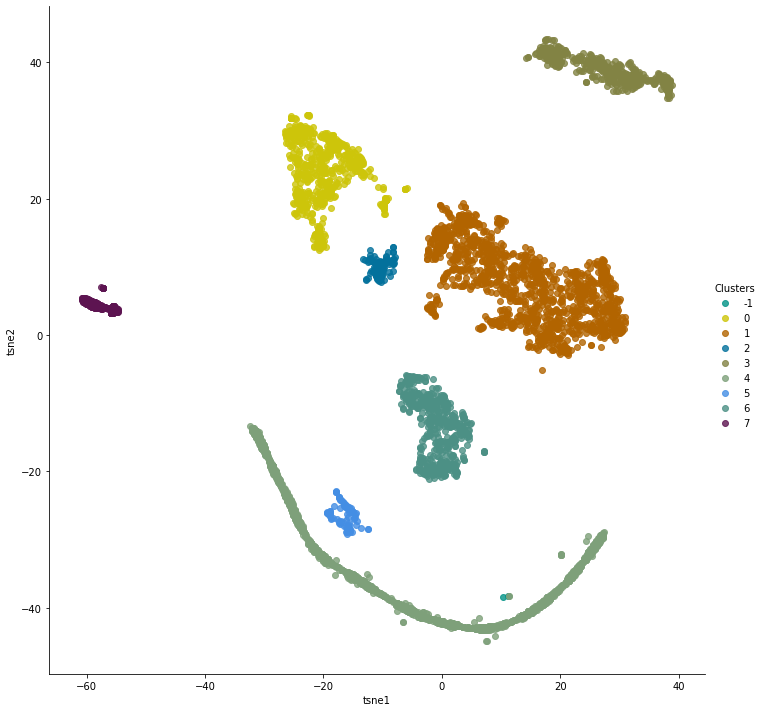

In [644]:

colors = pd.read_excel('../Desktop/Dataframes/Others/colors.xlsx')  #  библиотека красивых цветов
list(colors.iloc[:,0])
colors  = colors.iloc[:,0].str.strip()

random.shuffle(colors)

labels_dbs = DBSCAN(eps = 3.5, min_samples=28).fit_predict(tsne_repr_2d)
well_x['Clusters'] = labels_dbs


well_x['tsne1'] = tsne_repr_2d[:, 0]
well_x['tsne2'] = tsne_repr_2d[:, 1]
final_result_x = well_x[well_x['Clusters'] != -1]

sns.lmplot('tsne1', 'tsne2', data=well_x, hue = 'Clusters', palette=sns.xkcd_palette(colors), fit_reg=False, height=10)
plt.show()

In [646]:
well_x.to_excel('x_frame.xlsx', index = False)

In [697]:
database['well_0']

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log
0,0.285,13.518914,1.951250,0.018750,119.285295,95.875
8,0.285,13.518914,1.951250,0.018750,119.285295,95.875
16,0.285,13.518914,1.951250,0.018750,119.285295,95.875
24,0.285,13.518914,1.951250,0.018750,119.285295,95.875
32,0.285,13.518914,1.951250,0.018750,119.285295,95.875
...,...,...,...,...,...,...
26896,13.015,14.865000,2.041875,0.112969,119.285295,63.500
26904,13.300,14.865000,2.041875,0.112969,119.285295,63.500
26912,11.875,14.865000,2.041875,0.112969,119.285295,63.500
26920,13.490,14.865000,2.041875,0.112969,119.285295,63.500


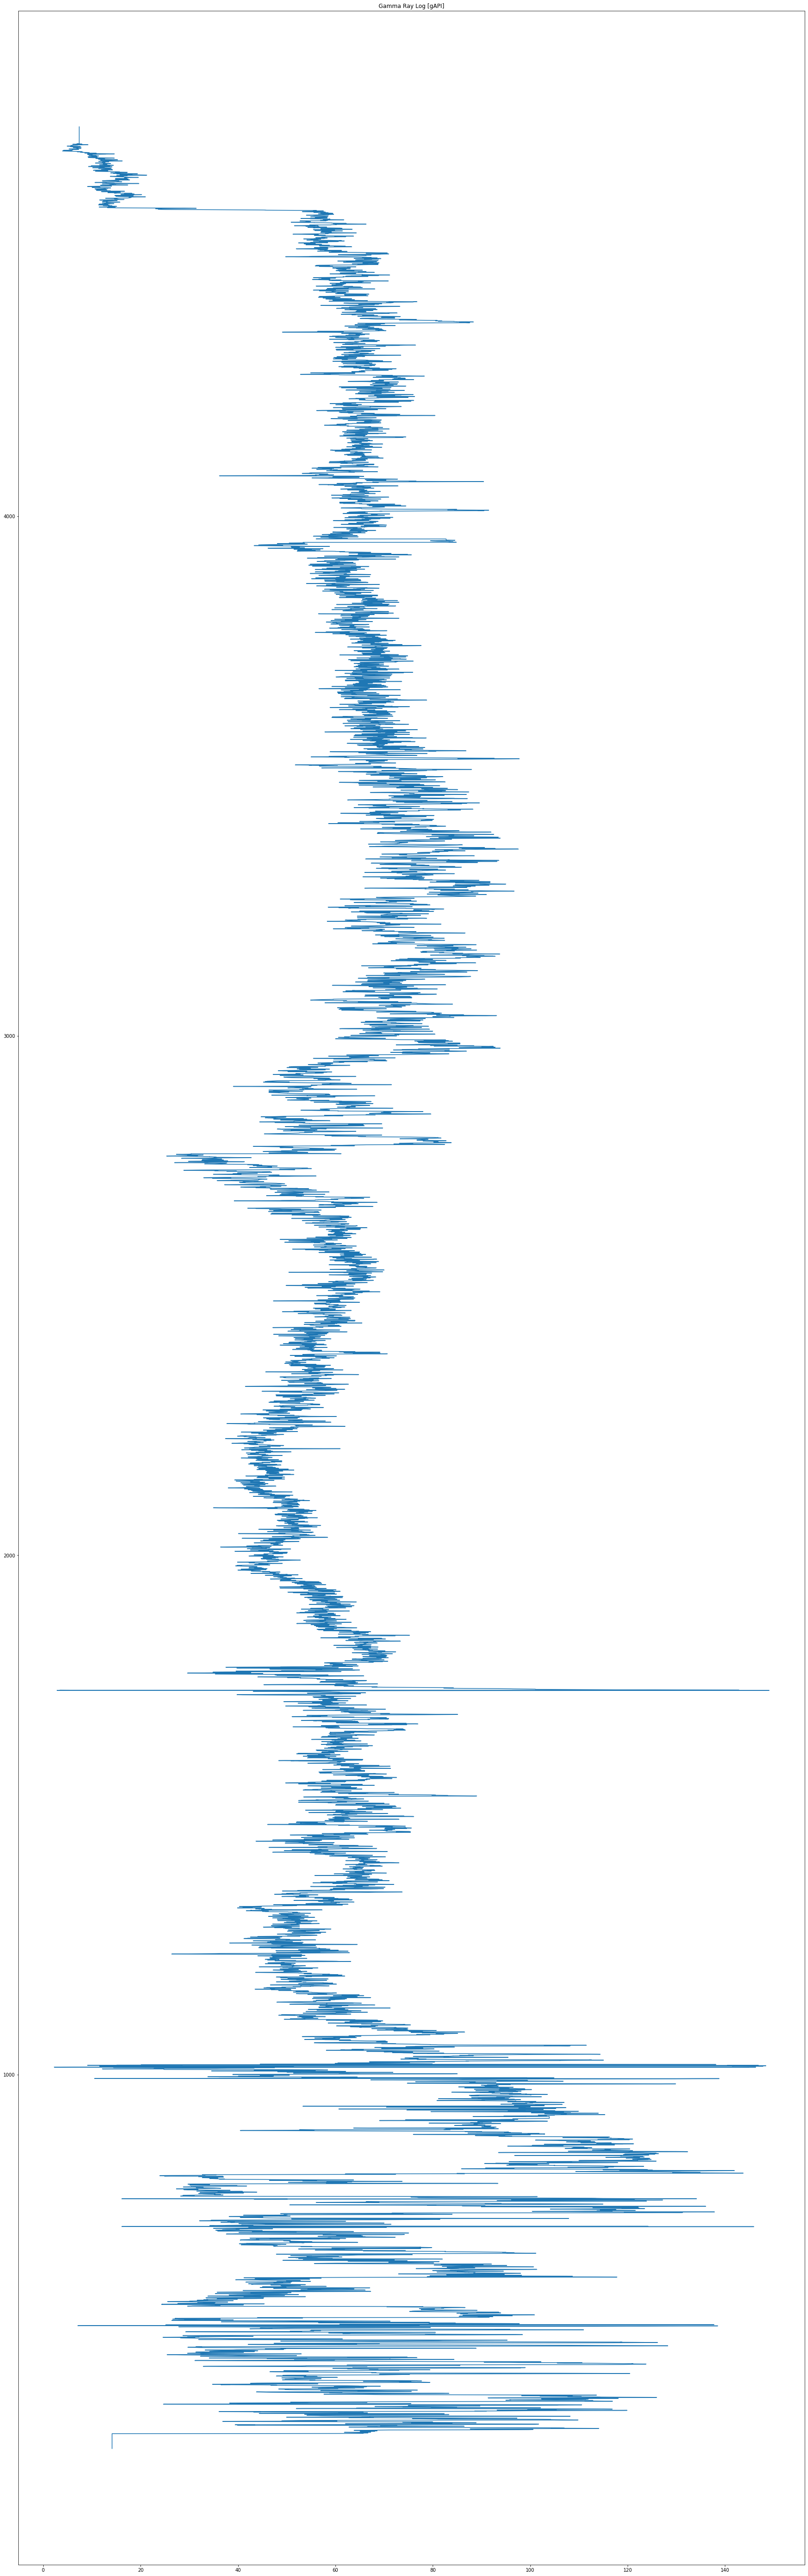

In [693]:
plt.figure(figsize = (30,100))
plt.plot(well_x['gamma_ray_log'], well_x['Depth'])
plt.title('Gamma Ray Log [gAPI]')
plt.savefig('Gamma Ray Log [gAPI].png')
# plt.yticks(well_x['Depth'])

In [698]:
low_depth = [380, 300, 200, 380, 200, 200, 270]  # tesseract
high_depth = [3800, 4420, 2980, 3860, 2190, 2290, 4940]

for l,h,i in zip(low_depth, high_depth, database.keys()):
    database[i]['Depth']  = np.linspace(l, h, database[i].shape[0])

In [703]:
database['well_0'].head(20)

,gamma_ray_log,caliper_log,bulk_log,neutron_log,sonic_log,medium_log,Depth
0,0.285,13.518914,1.95125,0.01875,119.285295,95.875,380.000000
8,0.285,13.518914,1.95125,0.01875,119.285295,95.875,381.016043
16,0.285,13.518914,1.95125,0.01875,119.285295,95.875,382.032086
24,0.285,13.518914,1.95125,0.01875,119.285295,95.875,383.048128
32,0.285,13.518914,1.95125,0.01875,119.285295,95.875,384.064171
40,0.285,13.518914,1.95125,0.01875,119.285295,95.875,385.080214
48,0.285,13.518914,1.95125,0.01875,119.285295,95.875,386.096257
56,0.285,13.518914,1.95125,0.01875,119.285295,95.875,387.112299
64,0.285,13.518914,1.95125,0.01875,119.285295,95.875,388.128342
72,0.285,13.518914,1.95125,0.01875,119.285295,95.875,389.144385
